$$
\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} + f(x,t), \quad f(x,t) = 0
$$
$$
u(x,0) = e^{-(x-5)^2}, \quad x \in [0,10]
$$

$$
u(0,t) = 0, \quad u(10,t) = 0, \quad t \geq 0
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spla

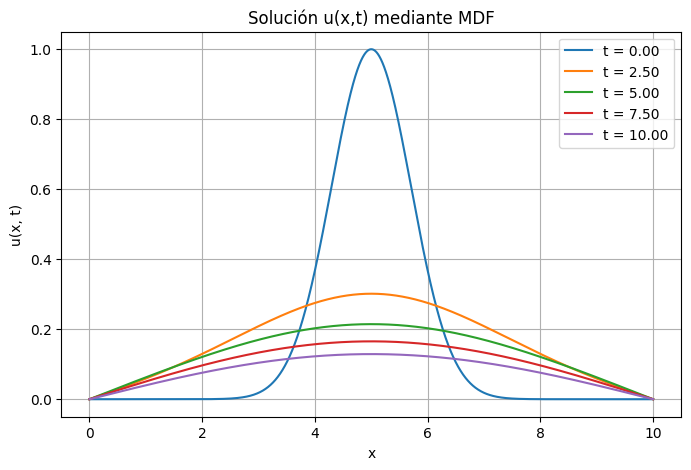

In [2]:
# RESOLUCION MEDIANTE MDF

# Parametros
eI, eD = 0, 10
T = 10
N = 10000
L = 10000
h = (eD - eI) / (N + 1)
tau = T / L
Lambda = tau / h**2

# Funciones
def uCero(x):
    return np.exp(-(x-5)**2)

def f(x, t):
    return np.zeros_like(x)

def alpha(t):
    return np.zeros_like(t)

def beta(t):
    return np.zeros_like(t)

# Matrices del esquema de Crank-Nicolson
I = sp.eye(N, N)
E = sp.diags([1], offsets=[1], shape=(N, N))
D = 2 * I - E - E.T
A = I + 0.5 * Lambda * D
B = I - 0.5 * Lambda * D

# Tiempos a plotear e indices
tiempos_a_plot = np.linspace(0, T, 5)
indices_plot = [int(t / tau) for t in tiempos_a_plot]

# Inicializacion
x = np.linspace(eI, eD, N + 2)
xInt = x[1:-1]
u0 = uCero(xInt)
b0 = tau * f(xInt, 0)
b0[0]  += Lambda * alpha(0)
b0[-1] += Lambda * beta(0)

# Estructura para guardar
soluciones = {}
if 0 in indices_plot:
    soluciones[0] = np.concatenate(([alpha(0)], u0, [beta(0)]))

# Bucle temporal
for k in range(1, L + 1):
    t_actual = k * tau
    b1 = tau * f(xInt, t_actual)
    b1[0]  += Lambda * alpha(t_actual)
    b1[-1] += Lambda * beta(t_actual)
    
    b = B @ u0 + 0.5 * b0 + 0.5 * b1
    u1 = spla.spsolve(A, b)
    
    b0, u0 = b1, u1
    
    if k in indices_plot:
        soluciones[k] = np.concatenate(([alpha(t_actual)], u0, [beta(t_actual)]))

# Representacion final
plt.figure(figsize=(8, 5))
for k, perfil in soluciones.items():
    tiempo = k * tau
    plt.plot(x, perfil, label=f"t = {tiempo:.2f}")

plt.xlabel("x")
plt.ylabel("u(x, t)")
plt.title("Solución u(x,t) mediante MDF")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from scipy.integrate import quad

# Parametros
N_terms = 50
L = 10
alpha = 1

def u0(y):
    return np.exp(-y**2)

def compute_bn(n):
    integrand = lambda y: u0(y - L/2) * np.sin(n * np.pi * y / L)
    bn, _ = quad(integrand, 0, L)
    return (2.0 / L) * bn

b = np.array([compute_bn(n) for n in range(1, N_terms + 1)])

def heat_solution_dirichlet(x, t, N_terms=N_terms):
    u = np.zeros_like(x)
    for n in range(1, N_terms + 1):
        u += b[n-1] * np.sin(n * np.pi * x / L) * np.exp(- (n * np.pi / L)**2 * alpha * t)
    return u

from sklearn.metrics import mean_squared_error

# Lista para almacenar errores en cada instante de tiempo
errores_mse = []

for k, perfil_num in soluciones.items():
    t = k * tau
    # Solucion exacta en el mismo vector x
    perfil_exacto = heat_solution_dirichlet(x, t)
    # Calculo del MSE entre perfil numerico y exacto
    mse = mean_squared_error(perfil_exacto, perfil_num)
    errores_mse.append((t, mse))

# Mostrar los errores
for t, mse in errores_mse:
    print(f"t = {t:.2f}, MSE = {mse:.3e}")

t = 0.00, MSE = 1.234e-24
t = 2.50, MSE = 5.410e-19
t = 5.00, MSE = 2.652e-19
t = 7.50, MSE = 3.543e-19
t = 10.00, MSE = 3.843e-19
